# Handwritten Text Recognition Project
### by Alex Misrahi, Youssef Chaaaaabouni, and Tim Valencony

According to [Wikipedia](https://en.wikipedia.org/wiki/Handwriting_recognition), HWTR is the ability of a computer to receive and interpret intellegible handwritten input from sources such as paper documents, photographs, touch-screens, and other devices. <br> </br>

In our case, we will only focus on handwritten sentences on paper. For this, we use the [IAM](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database) dataset which contains forms of handwritten English text that can be used to train and test handwritten text recognizers and to perform writer identification and verification experiments, hence perfect for what we aim to achieve. <br> </br>

There are several ways one can tackle this problem, but this notebook focuses solely on the segmentation implementation. In other terms, the IAM dataset provides us with pictures of words, we write an algorithm which takes those images and segments them into images of characters. We then feed those images of characters into our CNN composed Neural network, which predicts single characters, and with those predictions reassembled we have the prediction of a word. Let us see how this can actually be done.

## I. Image Treatment and Analysis

### 1. Data Exploration

In [34]:
import pandas as pd
import numpy as np

import matplotlib.image as img
import matplotlib.pyplot as plt

import cv2
import imutils
import pytesseract
from imutils.contours import sort_contours
import argparse
import random

In [4]:
## CREATING DICTIONNARY ASSOCIATING IMAGE FILENAME W/ IMAGE CONTENT
import os
d = dict()
size = 0
with open('ascii/words.txt','r') as f:
    for line in f.readlines():
        if line[0] != '#' and line.split()[1] == "ok":
            size += 1
            if size > 5000:
                break
            l = line.split()
            d[l[0]] = l[-1]

# EXAMPLE
print("Content of file a01-000u-00-00: ", d["a01-000u-00-00"])

Content of file a01-000u-00-00:  A


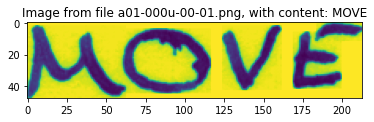

In [12]:
## PLOT OF IMAGE FROM DATASET
image = img.imread("./words/a01/a01-000u/a01-000u-00-01.png", 0)
plt.imshow(image)
plt.title(f'Image from file a01-000u-00-01.png, with content: {d["a01-000u-00-01"]}')
plt.show()

In [30]:
## FETCHING ALL THE DATASET
images = []
paths = []
shapes = [[], []]
for name in d.keys():
    path = "./words/"
    directories = name.split('-')
    path += directories[0] + "/"
    path += directories[0] + "-" + directories[1] + "/"
    path += name + ".png"
    paths.append(path)
    try:
        image = img.imread(path)
        images.append([image, d[name]])
        shapes[0].append(image.shape[0])
        shapes[1].append(image.shape[1])
        # LOOKING FOR PARTICULAR IMAGE
        #if image.shape[0] == 60:
            #plt.imshow(image)
    except:
        SyntaxError
images = np.array(images, dtype=object)

Now, every image is being contained in the *$images$* array, with first entry an array of size $n \times m$ (n being the length and m the height in pixels of the image) and the second entry being what it represents. Here is an example:

In [31]:
print(images[0])

[array([[0.9764706 , 0.9764706 , 0.9647059 , ..., 0.9843137 , 0.9843137 ,
         0.9843137 ],
        [0.98039216, 0.9764706 , 0.90588236, ..., 0.9843137 , 0.9843137 ,
         0.9843137 ],
        [0.9607843 , 0.94509804, 0.84705883, ..., 0.9843137 , 0.9843137 ,
         0.9843137 ],
        ...,
        [0.48235294, 0.7921569 , 0.91764706, ..., 0.36862746, 0.7607843 ,
         0.9137255 ],
        [0.5568628 , 0.85490197, 0.9411765 , ..., 0.61960787, 0.9019608 ,
         0.94509804],
        [0.6392157 , 0.9137255 , 0.94509804, ..., 0.8666667 , 0.92941177,
         0.9490196 ]], dtype=float32)
 'A']


Below is a plot of an image taken at *random* from the dataset:

Image with written text: '  with  ' 


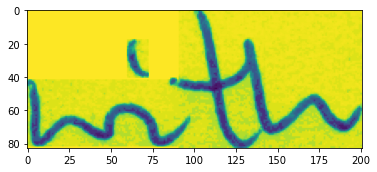

In [46]:
t = random.randint(0, len(images))
random_image = images[t][0]
plt.imshow(random_image)
print("Image with written text: \' ", images[t][1], " \' ")

Out of curiousity, and for plausible future use, we show below the max height/width.

In [37]:
# MAX HEIGHT AND WIDTH
max_height, max_width = max(shapes[0]), max(shapes[1])
max_height, max_width

(211, 820)

Here is also a plot of a complete sentence from the dataset:

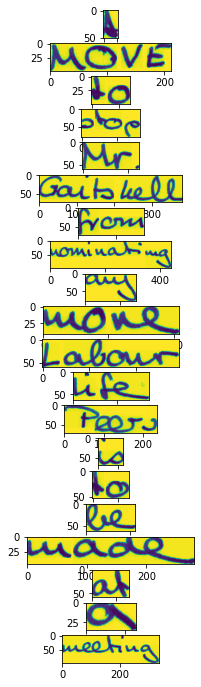

In [38]:
fig, axs = plt.subplots(20, figsize = (180, 12))
for i in range(20):
    axs[i].imshow(images[i][0])

#### Some plots

Below is a plot with $x-axis$ representing the height of each image vs its heigh:

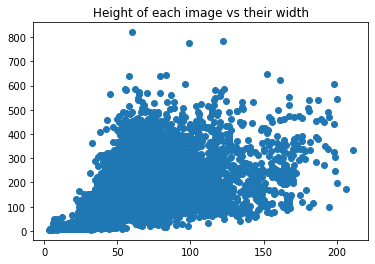

In [40]:
plt.scatter(shapes[0], shapes[1])
plt.title("Height of each image vs their width")
plt.show()

Here are the repartition of heights and widths from our dataset, giving us a good general idea of the *typical image*.

(array([ 318.,  565., 1598., 1290.,  548.,  363.,  141.,  118.,   42.,
          16.]),
 array([  3. ,  23.8,  44.6,  65.4,  86.2, 107. , 127.8, 148.6, 169.4,
        190.2, 211. ]),
 <BarContainer object of 10 artists>)

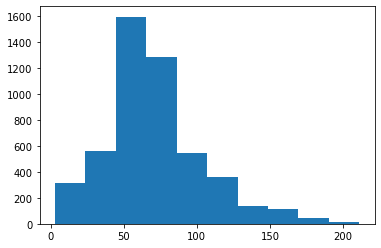

In [41]:
# heights
plt.hist(shapes[0])

(array([1157., 1475., 1018.,  734.,  369.,  187.,   44.,   12.,    0.,
           3.]),
 array([  4. ,  85.6, 167.2, 248.8, 330.4, 412. , 493.6, 575.2, 656.8,
        738.4, 820. ]),
 <BarContainer object of 10 artists>)

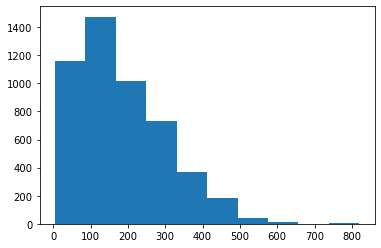

In [42]:
# widths
plt.hist(shapes[1])

In case it is needed, we can *reshape* every image in order for them to have the same height and width, although this is going to lead to problems if one wants to for example predict a point **"."**.

In [43]:
# Adding blank space to adapt shape
def reshape_image(im, new_height, new_width, value=1):
    x,y = im.shape  
    (pad_y_top, pad_y_down) = ((new_height-x)//2, (new_height-x)//2) if ((new_height-x) % 2 == 0) else ((new_height-x)//2 + 1, (new_height-x)//2)
    (pad_x_right, pad_x_left) = ((new_width-y)//2, (new_width-y)//2) if ((new_width-y) % 2 == 0) else ((new_width-y)//2 + 1, (new_width-y)//2)
    return np.pad(im, ((pad_y_top, pad_y_down), (pad_x_left, pad_x_right)), 'constant', constant_values=value)

This is what results from the reshaping:

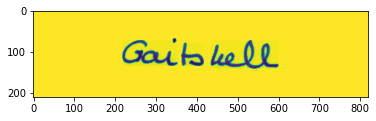

In [44]:
adapted = reshape_image(images[5][0], max_height, max_width)
plt.imshow(adapted)

### 2. Segmentation

We can use the previously randomly selected image, which we will show again:

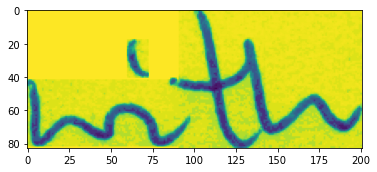

In [49]:
plt.imshow(random_image)
plt.show()

Now, we will increase the **contrast** on the image so that it is easier to grasp exactly what parts we want the algorithm to look at:

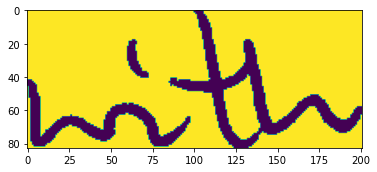

In [51]:
# Change image focus
image = random_image > 0.85
image = image.astype(int)
plt.imshow(image)

Again, for improvement of the efficiency of our segmentation algorithm, we only want to look at the edges of the letter:

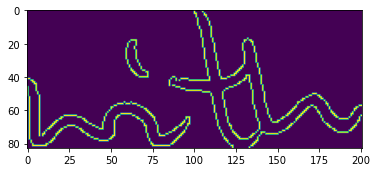

In [53]:
edged = cv2.Canny(np.uint8(image), 1, 1)
plt.imshow(edged)
plt.show()

Now, we us the **cv2** library in order to create the boxes around the characters:

In [55]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

chars = []
for ctr in cnts:
    x, y, w, h = cv2.boundingRect(ctr)
    roi = image[:, x:x+w]
    # thresh = cv2.threshold(np.round(roi*255), 0, 255,cv2.THRESH_OTSU)[1]
    if (h>20 or w>20 and h<100 and w<100):
        chars.append(roi)

Finally, we **plot** the boxed out areas, which are the characters that the algorithm identified in the image:

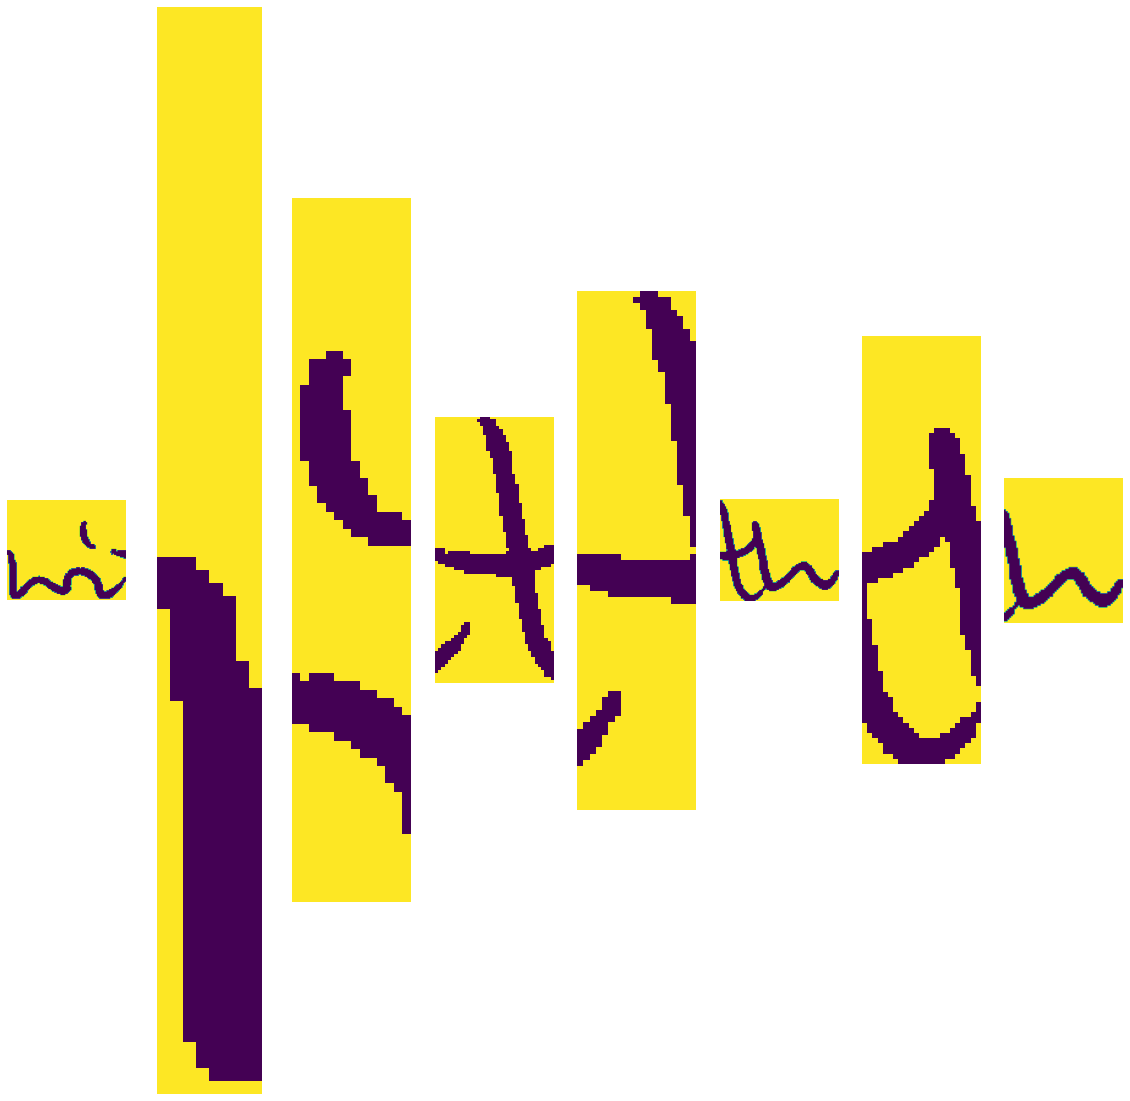

In [57]:
def plot_chars(chars):
    n = len(chars)
    fig, axs = plt.subplots(1, n, figsize = (20, 20))
    for i in range(n):
        axs[i].imshow(chars[i])
        axs[i].axis('off')

plot_chars(chars)

Here we can see where the boxes were selected:

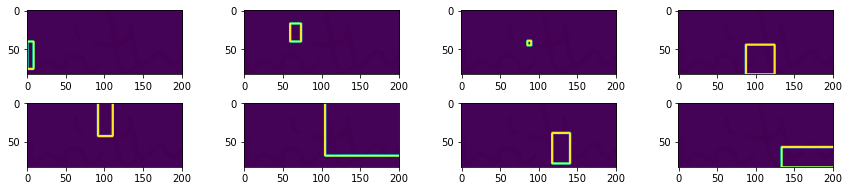

In [71]:
fig, ax = plt.subplots(2, 4,figsize=(14, 22))
rectangles = None
i = 0
for ctr in cnts:
    x, y, w, h = cv2.boundingRect(ctr)
    if(h>20 or w>20 and h<100 and w<100):
        if rectangles is None:
            rectangles = cv2.rectangle(np.float32(image),(x,y),(x+w,y+h),(90,0,1),2)
            continue
    if i < 4:
        ax[0, i].imshow(cv2.rectangle(np.float32(image),(x,y),(x+w,y+h),(90,0,1),2))
    else: 
        ax[1, i-4].imshow(cv2.rectangle(np.float32(image),(x,y),(x+w,y+h),(90,0,1),2))
    rectangles = rectangles + cv2.rectangle(np.float32(image),(x,y),(x+w,y+h),(90,0,1),2)
    i += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.2, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

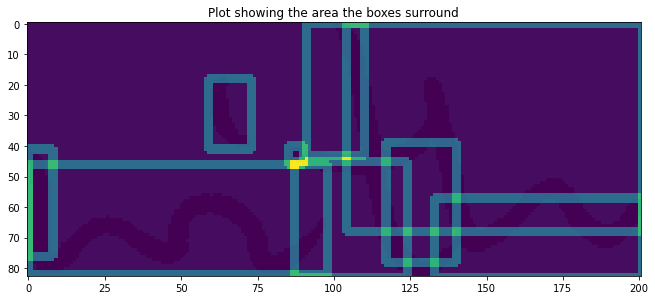

In [73]:
plt.figure(figsize=(11, 18))
plt.imshow(rectangles)
plt.title("Plot showing the area the boxes surround")
plt.show()

#### Sources:
1. [Handwritten Text Recognition using Deep Learning (Stanford)](http://vision.stanford.edu/teaching/cs231n/reports/2017/pdfs/810.pdf)
2. [An Intuitive Explanation of Connectionist Temporal Classification](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)